# 情感分析：使用卷积神经网络

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size = 64
train_iter, test_iter, vocab = d2l.load_data_imdb(batch_size)

## 一维卷积

**数学公式推导**
设：<br>
输入长度：L = len(X)<br>
核长度：w = len(K)<br>
起始位置 i 的取值范围：0 ≤ i ≤ L - w<br>
计算有效位置数量<br>
**最小起始位置：** i = 0（从开头开始）<br>
**最大起始位置：** i = L - w（最后一组不越界的位置）<br>
**总位置数：**`(最大位置) - (最小位置) + 1 = (L - w) - 0 + 1 = L - w + 1`

In [2]:
'''
X：输入的一维张量（如时间序列、文本序列）
K：一维卷积核（kernel）
w：卷积核的长度（宽度）   
'''
def corr1d(X, K):
    w = K.shape[0]
    # 初始化输出张量Y，其长度为len(X)-len(K)+1
    Y = torch.zeros((X.shape[0] - w + 1))
    for i in range(Y.shape[0]):
        # X[i:i+w]：从输入中提取与卷积核等长的片段
        # *K：与卷积核逐元素相乘
        # .sum()：将乘积结果求和，得到该位置的输出值
        Y[i] = (X[i: i + w] * K).sum()
    return Y

![](./img/一维卷积1.png)

In [3]:
X, K = torch.tensor([0, 1, 2, 3, 4, 5, 6]), torch.tensor([1, 2])
corr1d(X, K)

tensor([ 2.,  5.,  8., 11., 14., 17.])

![](./img/一维卷积2.png)

In [4]:
'''
X：多通道输入，形状(通道数,序列长度)
K：多通道卷积核，形状(通道数,核长度)
zip(X,K)：将输入和核按通道配对
sum(...)：将所有通道的计算结果逐元素相加，合并为单一输出
'''
def corr1d_multi_in(X, K):
    # 首先，遍历'X'和'K'的第0维（通道维）。然后，把它们加在一起
    return sum(corr1d(x, k) for x, k in zip(X, K))

X = torch.tensor([[0, 1, 2, 3, 4, 5, 6],
              [1, 2, 3, 4, 5, 6, 7],
              [2, 3, 4, 5, 6, 7, 8]])
K = torch.tensor([[1, 2], [3, 4], [-1, -3]])
corr1d_multi_in(X, K)

tensor([ 2.,  8., 14., 20., 26., 32.])

## 最大时间汇聚层

## textCNN模型

### 定义模型

In [5]:
class TextCNN(nn.Module):
    '''
    输入索引序列 (batch, seq_len)
        ↓
    双嵌入层 → 拼接 (batch, seq_len, 2*embed_size)
        ↓ 转置 (batch, 2*embed_size, seq_len)
    多尺度卷积 → 分支1(k=3)、分支2(k=4)、分支3(k=5)
        ↓ 每个分支输出 (batch, channels, seq_len-k+1)
    自适应池化 → 每个分支输出 (batch, channels, 1)
        ↓ 拼接所有分支
    特征向量 (batch, sum(num_channels))
        ↓ Dropout + Linear
    分类输出 (batch, 2)
    vocab_size：词汇表大小（如10002）
    embed_size：词嵌入维度（如100）
    kernel_sizes：卷积核大小列表（如[3,4,5]）
    num_channels：每个卷积核对应的输出通道数列表（如[100,100,100]）
    '''
    def __init__(self, vocab_size, embed_size, kernel_sizes, num_channels,
                 **kwargs):
        super(TextCNN, self).__init__(**kwargs)
        '''
        1. 双嵌入层策略（TextCNN特色）
        embedding：可训练的嵌入层，学习领域特定表示
        constant_embedding：固定嵌入层，用于加载预训练向量（如GloVe），且不更新
        作用：结合动态学习与静态预训练优势，增强特征丰富度
        '''
        self.embedding = nn.Embedding(vocab_size, embed_size)
        '''
        # 这个嵌入层不需要训练
        2. 输出层
        sum(num_channels)：所有卷积层输出通道数总和（如300）
        decoder：全连接层，将多卷积特征聚合为二分类输出
        dropout：防止过拟合（丢弃概率0.5）
        '''
        self.constant_embedding = nn.Embedding(vocab_size, embed_size)
        self.dropout = nn.Dropout(0.5)
        self.decoder = nn.Linear(sum(num_channels), 2)
        '''
        # 最大时间汇聚层没有参数，因此可以共享此实例
        3. 特征池化层
        pool ：自适应平均池化，将任意长度的特征序列压缩为1个值
        输入：(通道数,长度)→输出：(通道数,1)
        关键：解决可变长度序列问题，提取最显著特征
        relu：激活函数实例
        '''
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.relu = nn.ReLU()
        '''
        # 创建多个一维卷积层
        4. 多尺度卷积层
        nn.ModuleList()：存储多个子模块的列表
        2*embed_size：输入维度=两个嵌入层拼接后的维度
        例如：嵌入100维+预训练100维=200维
        c：输出通道数（每个卷积核独立设置）
        k：卷积核大小（时间窗口），捕捉不同长度的n-gram特征
        k=3：捕捉trigram特征
        k=4：捕捉4-gram特征
        k=5：捕捉5-gram特征
        '''
        self.convs = nn.ModuleList()
        for c, k in zip(num_channels, kernel_sizes):
            self.convs.append(nn.Conv1d(2 * embed_size, c, k))

    def forward(self, inputs):
        '''
        # 沿着向量维度将两个嵌入层连结起来，
        # 每个嵌入层的输出形状都是（批量大小，词元数量，词元向量维度）连结起来
        inputs 形状：(批量大小,词元数量) 
        1. 双嵌入层拼接
        两个嵌入层各自产生形状(batch,seq_len,embed_size) 的张量
        dim=2：沿嵌入维度拼接，得到 (batch,seq_len,2*embed_size)
        目的：结合可训练嵌入（学习领域特征）和固定嵌入（保留通用语义）
        '''
        embeddings = torch.cat((
            self.embedding(inputs), self.constant_embedding(inputs)), dim=2)
        '''
        # 根据一维卷积层的输入格式，重新排列张量，以便通道作为第2维
        2. 调整维度顺序适配Conv1d
        转置后形状：(batch,2*embed_size,seq_len)
        原因：PyTorch的Conv1d要求输入为(batch,channels,length)格式
        此时2*embed_size被视为输入通道数
        '''
        embeddings = embeddings.permute(0, 2, 1)
        '''
        # 每个一维卷积层在最大时间汇聚层合并后，获得的张量形状是（批量大小，通道数，1）
        # 删除最后一个维度并沿通道维度连结
        3. 多尺度卷积+池化（核心）
        单分支处理（以某个卷积层为例）：
        conv(embeddings)：卷积操作
        输入：(batch,2*embed_size,seq_len);输出：(batch,out_channels,seq_len-k+1)
        self.pool(...)：自适应最大池化
        nn.AdaptiveMaxPool1d(1)：将每个通道的序列压缩为1个最大值
        输出：(batch,out_channels,1);作用：提取每个通道最显著的特征，解决变长序列问题
        torch.squeeze(..., dim=-1)：删除最后一个维度;输出：(batch,out_channels)
        跨分支拼接：
        列表推导遍历所有卷积层（如3个不同大小的核）
        dim=1：沿通道维度拼接所有分支输出
        最终encoding形状：(batch,sum(num_channels))，如 (64,300)
        '''
        encoding = torch.cat([
            torch.squeeze(self.relu(self.pool(conv(embeddings))), dim=-1)
            for conv in self.convs], dim=1)
        '''
        4. 分类输出
        self.dropout(encoding)：对拼接特征应用Dropout，防止过拟合
        self.decoder：全连接层，将特征映射到2个输出节点
        输出形状：(batch,2)，表示每个样本的负/正情感logits
        '''
        outputs = self.decoder(self.dropout(encoding))
        return outputs

让我们创建一个textCNN实例。它有3个卷积层，卷积核宽度分别为3、4和5，均有100个输出通道。


In [6]:
embed_size, kernel_sizes, nums_channels = 100, [3, 4, 5], [100, 100, 100]
devices = d2l.try_all_gpus()
net = TextCNN(len(vocab), embed_size, kernel_sizes, nums_channels)

def init_weights(m):
    if type(m) in (nn.Linear, nn.Conv1d):
        nn.init.xavier_uniform_(m.weight)

net.apply(init_weights);

### 加载预训练词向量

与`sec_sentiment_rnn`相同，我们加载预训练的100维GloVe嵌入作为初始化的词元表示。这些词元表示（嵌入权重）在`embedding`中将被训练，在`constant_embedding`中将被固定。


In [7]:
# 1. 加载GloVe预训练词向量：加载在60亿词上训练的100维GloVe词向量,包含约40万个通用英语词汇的语义表示
glove_embedding = d2l.TokenEmbedding('glove.6b.100d')
'''
2. 提取词汇表对应的向量
vocab.idx_to_token：模型词汇表中的所有词元（含特殊符号如<pad>、<unk>）
批量查询：一次性获取词汇表中所有词的预训练向量
结果形状：(vocab_size,100)，如(10002,100)
'''
embeds = glove_embedding[vocab.idx_to_token]
'''
3. 将向量复制到可训练嵌入层
net.embedding：模型中可训练的嵌入层
复制权重：用GloVe向量替换随机初始化
允许更新：requires_grad=True（默认），训练时会继续微调这些向量
'''
net.embedding.weight.data.copy_(embeds)
'''
4. 将向量复制到固定嵌入层
net.constant_embedding：模型中固定不变的嵌入层
同样初始化：也加载GloVe向量作为初始值
关键点：冻结权重（requires_grad=False）
训练时不更新，始终保留原始GloVe语义空间
提供稳定的通用语义表示
'''
net.constant_embedding.weight.data.copy_(embeds)
net.constant_embedding.weight.requires_grad = False

### 训练和评估模型

现在我们可以训练textCNN模型进行情感分析。


loss 0.066, train acc 0.980, test acc 0.861
4228.3 examples/sec on [device(type='cuda', index=0)]


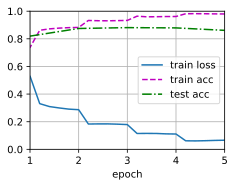

In [8]:
lr, num_epochs = 0.001, 5
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

下面，我们使用训练好的模型来预测两个简单句子的情感。


In [9]:
d2l.predict_sentiment(net, vocab, 'this movie is so great')

'positive'

In [10]:
d2l.predict_sentiment(net, vocab, 'this movie is so bad')

'negative'